<a href="https://colab.research.google.com/github/Lubraca/Unsupervised_ML_Models/blob/main/PCA/PCA_Projectipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


In [2]:
# Load the data

# Keep only people with at least N images to avoid extreme class imbalance
MIN_FACES_PER_PERSON = 70

lfw = fetch_lfw_people(min_faces_per_person=MIN_FACES_PER_PERSON, resize=0.4)

X = lfw.data          # shape: (n_samples, n_features)
y = lfw.target        # integer labels
target_names = lfw.target_names
images = lfw.images   # shape: (n_samples, h, w)

print("X shape:", X.shape)
print("Number of classes:", len(target_names))
print("Image shape:", images[0].shape)


X shape: (1288, 1850)
Number of classes: 7
Image shape: (50, 37)


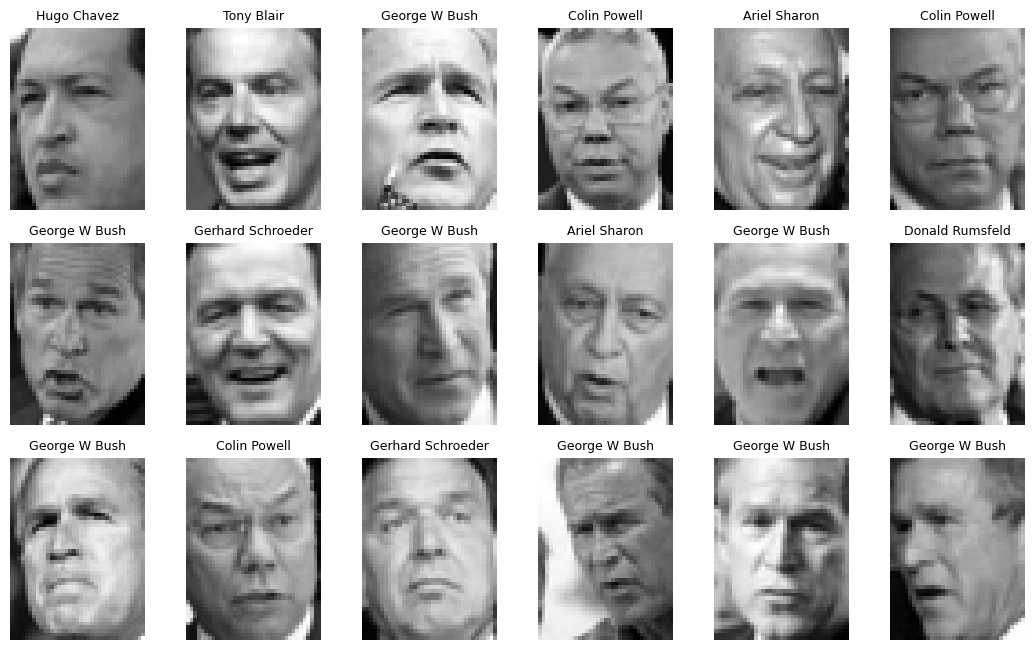

George W Bush            : 530
Colin Powell             : 236
Tony Blair               : 144
Donald Rumsfeld          : 121
Gerhard Schroeder        : 109
Ariel Sharon             : 77
Hugo Chavez              : 71


In [3]:
# Visualize some faces and classes distribution

def plot_gallery(images, titles=None, n_row=3, n_col=6):
    plt.figure(figsize=(1.8 * n_col, 2.2 * n_row))
    for i in range(n_row * n_col):
        ax = plt.subplot(n_row, n_col, i + 1)
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(titles[i], fontsize=9)
    plt.tight_layout()
    plt.show()

# Show a few samples
sample_titles = [target_names[y[i]] for i in range(18)]
plot_gallery(images[:18], sample_titles, n_row=3, n_col=6)

# Class counts
unique, counts = np.unique(y, return_counts=True)
for cls, c in sorted(zip(unique, counts), key=lambda x: -x[1]):
    print(f"{target_names[cls]:25s}: {c}")



In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (966, 1850) Test: (322, 1850)


In [5]:
#Pipeline: StandardScaler → PCA → SVM + GridSearch

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("pca", PCA(whiten=True, random_state=42)),
    ("svc", SVC(class_weight="balanced"))
])

param_grid = {
    "pca__n_components": [50, 100, 150],
    "svc__C": [1, 5, 10, 50],
    "svc__gamma": [0.0005, 0.001, 0.005, 0.01],
    "svc__kernel": ["rbf"]
}

search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV score:", search.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'pca__n_components': 100, 'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV score: 0.8437049302921853


                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.68      0.81        19
     Colin Powell       0.92      0.92      0.92        59
  Donald Rumsfeld       0.89      0.57      0.69        30
    George W Bush       0.79      0.99      0.88       133
Gerhard Schroeder       0.87      0.74      0.80        27
      Hugo Chavez       1.00      0.61      0.76        18
       Tony Blair       0.97      0.78      0.86        36

         accuracy                           0.85       322
        macro avg       0.92      0.76      0.82       322
     weighted avg       0.87      0.85      0.85       322



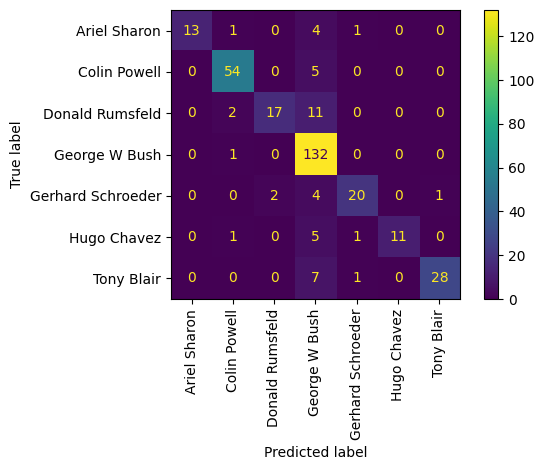

In [6]:
# test evaluation

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test,
    display_labels=target_names,
    xticks_rotation=90,
    values_format="d"
)
plt.tight_layout()
plt.show()

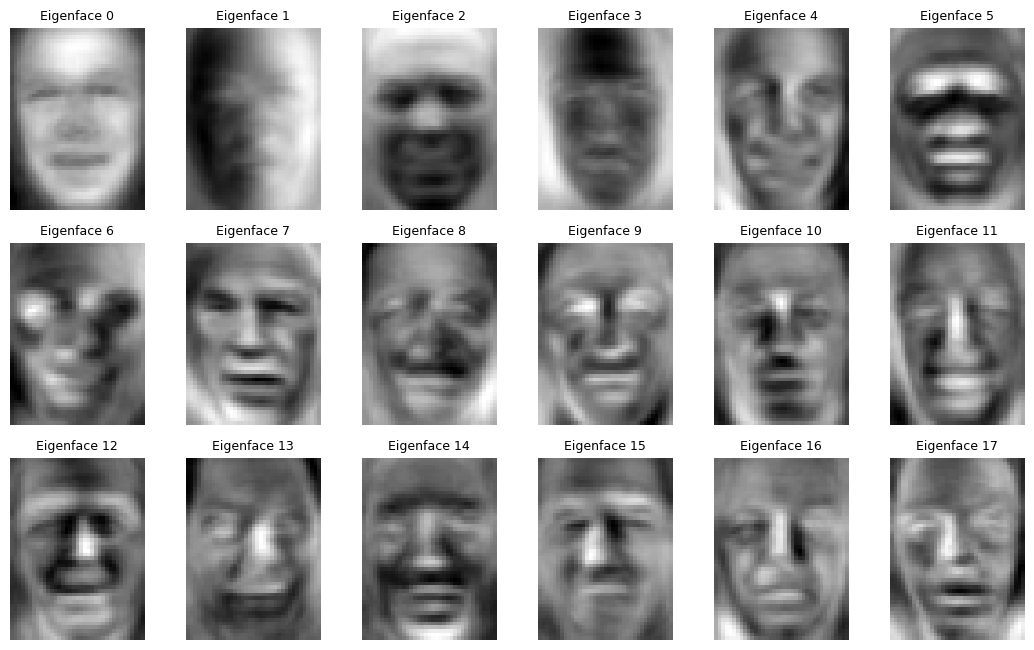

Chosen PCA components: 100
Explained variance ratio sum: 0.91334206


In [7]:
# Visualize eigenfaces

pca = best_model.named_steps["pca"]
h, w = images[0].shape

eigenfaces = pca.components_.reshape((pca.n_components_, h, w))

titles = [f"Eigenface {i}" for i in range(18)]
plot_gallery(eigenfaces[:18], titles, n_row=3, n_col=6)

print("Chosen PCA components:", pca.n_components_)
print("Explained variance ratio sum:", pca.explained_variance_ratio_.sum())


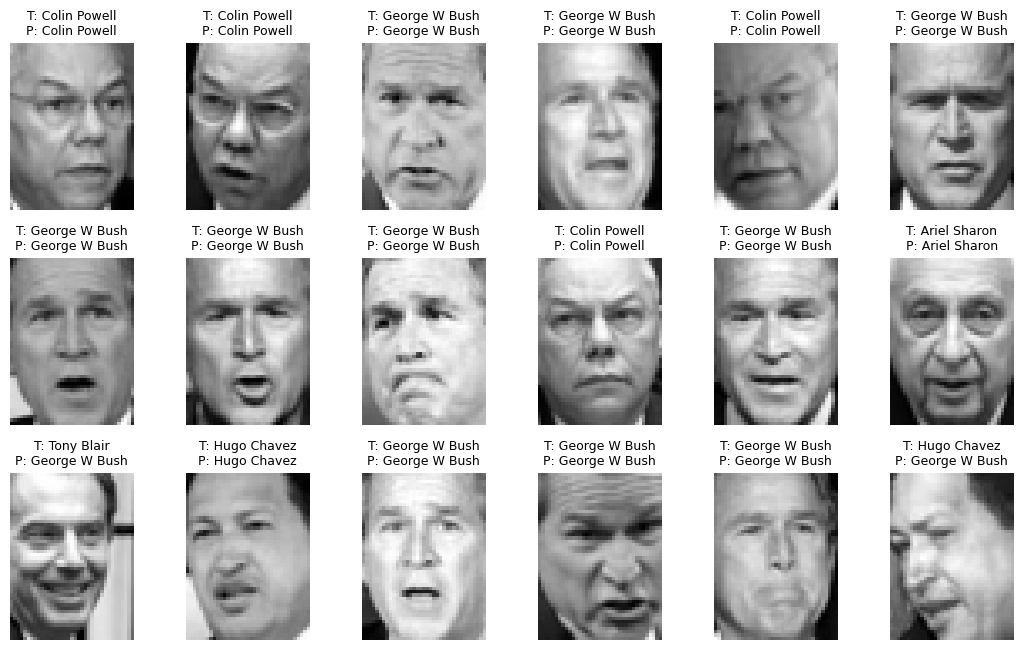

Number of mistakes: 47


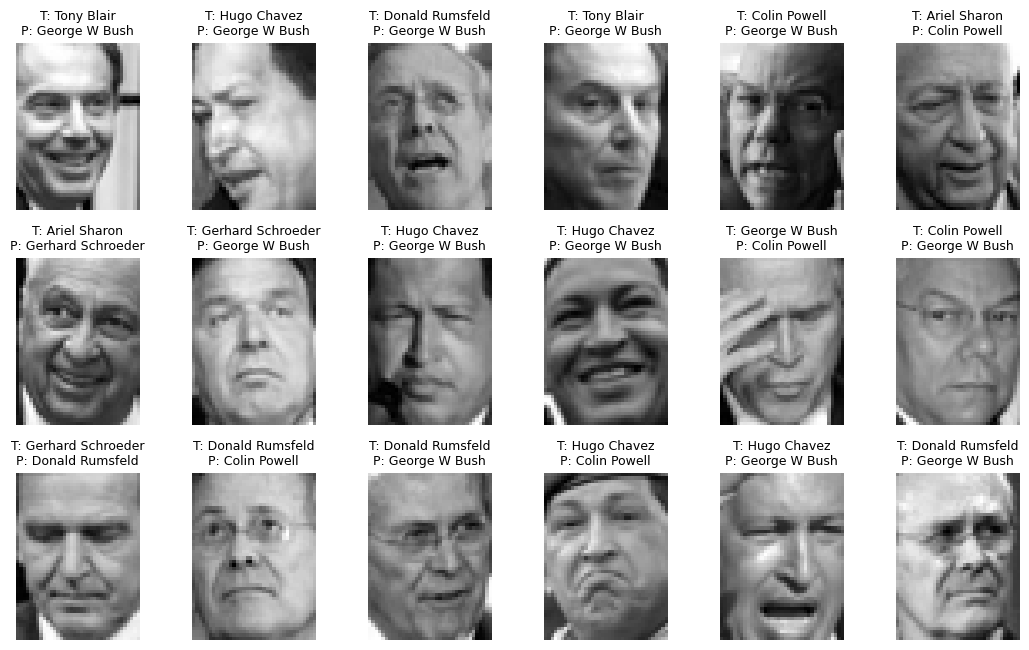

In [8]:
def plot_predictions(images, y_true, y_pred, target_names, n=18):
    titles = []
    for i in range(n):
        true_name = target_names[y_true[i]]
        pred_name = target_names[y_pred[i]]
        titles.append(f"T: {true_name}\nP: {pred_name}")
    plot_gallery(images[:n], titles, n_row=3, n_col=6)

# We need the test images (in 2D), but lfw.images is aligned with lfw.data.
# Let's reconstruct indexes by splitting with indices:
idx = np.arange(X.shape[0])
idx_train, idx_test, _, _ = train_test_split(
    idx, y, test_size=0.25, random_state=42, stratify=y
)

test_images = images[idx_test]

plot_predictions(test_images, y_test, y_pred, target_names, n=18)

# Focus on mistakes
mistakes = np.where(y_pred != y_test)[0]
print("Number of mistakes:", len(mistakes))

if len(mistakes) > 0:
    m = mistakes[:18]
    plot_predictions(test_images[m], y_test[m], y_pred[m], target_names, n=len(m))
